In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
from collections import Counter

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import precision_recall_curve,f1_score, fbeta_score, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

import pickle
import json



## XGBoost Models

After utilizing logistic regression as the baseline, and doing some cursory testing on K Nearest Neighbors and Naive Bayes, I spent more time working with Random Forest models and XGBoost models, in order to understand their parameters.  

Due to the life or death nature of medical data, recall was the measure of choice here, specifically recall on the minority class, which were the deaths.  I did also briefly consider using an F2.  However, that seemed to result in overfitting as I was attempting to tune, so I returned to minority class recall as the metric of preference.

Using the full metric classification report while adjust XGBoost parameters helped me to better understand how the parameters worked, and also to observe the precision/recall and majority/minority class tradeoffs as they shifted.

### The Full Dataset

In [3]:
covid_clean = pd.read_json('covid_no_nan.json', lines=True)
covid_clean.shape

(561096, 24)

In [5]:
features = ['sex','patient_type', 'pneumonia', 'diabetes', 'copd', 'asthma', 'inmsupr',
       'hypertension', 'other_disease', 'cardiovascular', 'obesity',
       'renal_chronic', 'tobacco', 'pregnancy',  'covid_res',
       'contact_other_covid']

x = covid_clean[features]
y = covid_clean['passed']

# train / test split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, \
                                                random_state=33, \
                                                stratify = y.values)

# train /validation split
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.2, \
                                             random_state=33,\
                                             stratify=ytrain.values)

In [14]:
boost = xgb.XGBClassifier(
            n_estimators=1000,
            max_depth=4,
            objective='binary:logistic',
            use_label_encoder=False,
            learning_rate=.05,
            subsample=.8,
            min_child_weight=2,
            colsample_bytree=.8)

eval_set =[(xtrain,ytrain), (xval, yval)]

fit_model = boost.fit(
            xtrain, ytrain,
            eval_set=eval_set,
            eval_metric='error',  # metric: classification error. could also use AUC,etc
            early_stopping_rounds=50,
            verbose=False)

[0]	validation_0-error:0.06336	validation_1-error:0.06336
[1]	validation_0-error:0.06336	validation_1-error:0.06336
[2]	validation_0-error:0.06336	validation_1-error:0.06336
[3]	validation_0-error:0.06336	validation_1-error:0.06336
[4]	validation_0-error:0.06336	validation_1-error:0.06336
[5]	validation_0-error:0.06336	validation_1-error:0.06336
[6]	validation_0-error:0.06336	validation_1-error:0.06336
[7]	validation_0-error:0.06336	validation_1-error:0.06336
[8]	validation_0-error:0.06336	validation_1-error:0.06336
[9]	validation_0-error:0.06336	validation_1-error:0.06336
[10]	validation_0-error:0.06336	validation_1-error:0.06336
[11]	validation_0-error:0.06336	validation_1-error:0.06336
[12]	validation_0-error:0.06336	validation_1-error:0.06336
[13]	validation_0-error:0.06336	validation_1-error:0.06336
[14]	validation_0-error:0.06336	validation_1-error:0.06336
[15]	validation_0-error:0.06336	validation_1-error:0.06336
[16]	validation_0-error:0.06336	validation_1-error:0.06336
[17]	va

[139]	validation_0-error:0.06233	validation_1-error:0.06180
[140]	validation_0-error:0.06232	validation_1-error:0.06180
[141]	validation_0-error:0.06232	validation_1-error:0.06180
[142]	validation_0-error:0.06233	validation_1-error:0.06178
[143]	validation_0-error:0.06233	validation_1-error:0.06180
[144]	validation_0-error:0.06233	validation_1-error:0.06180
[145]	validation_0-error:0.06233	validation_1-error:0.06180
[146]	validation_0-error:0.06233	validation_1-error:0.06181
[147]	validation_0-error:0.06233	validation_1-error:0.06181
[148]	validation_0-error:0.06234	validation_1-error:0.06177
[149]	validation_0-error:0.06233	validation_1-error:0.06176
[150]	validation_0-error:0.06233	validation_1-error:0.06176
[151]	validation_0-error:0.06232	validation_1-error:0.06177
[152]	validation_0-error:0.06233	validation_1-error:0.06178
[153]	validation_0-error:0.06233	validation_1-error:0.06178


In [16]:
gbm_cm = confusion_matrix(yval, boost.predict(xval))
gbm_cm

array([[83759,   423],
       [ 5128,   567]])

In [18]:
print(classification_report(yval, boost.predict(xval)))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     84182
           1       0.57      0.10      0.17      5695

    accuracy                           0.94     89877
   macro avg       0.76      0.55      0.57     89877
weighted avg       0.92      0.94      0.92     89877



In [19]:
boost2 = xgb.XGBClassifier(
            n_estimators=30000,  # increased
            max_depth=4,
            objective='binary:logistic',
            use_label_encoder=False,
            learning_rate=.1, # increased
            subsample=1,          # increased - row subsampling rate
            min_child_weight=2,
            colsample_bytree=1)   # increased - feature subsampling rate

eval_set =[(xtrain,ytrain), (xval, yval)]

fit_model = boost2.fit(
            xtrain, ytrain,
            eval_set=eval_set,
            eval_metric='error',  # metric: classification error. could also use AUC,etc
            early_stopping_rounds=50,
            verbose=False)

In [20]:
# more positives, more false negatives
gbm2_cm = confusion_matrix(yval, boost2.predict(xval))
gbm2_cm

array([[83725,   457],
       [ 5092,   603]])

In [21]:
# slight increase in minority class metrics
print(classification_report(yval, boost2.predict(xval)))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     84182
           1       0.57      0.11      0.18      5695

    accuracy                           0.94     89877
   macro avg       0.76      0.55      0.57     89877
weighted avg       0.92      0.94      0.92     89877



In [22]:
boost3 = xgb.XGBClassifier(
            n_estimators=30000,
            max_depth=4,
            objective='binary:logistic',
            use_label_encoder=False,
            learning_rate=.5, # increased
            subsample=1,          # row subsampling rate
            min_child_weight=1, # decreased
            colsample_bytree=1)   # feature subsampling rate

eval_set =[(xtrain,ytrain), (xval, yval)]

fit_model = boost3.fit(
            xtrain, ytrain,
            eval_set=eval_set,
            eval_metric='error',  # metric: classification error. could also use AUC,etc
            early_stopping_rounds=50,
            verbose=False)

In [23]:
# fewer positives, more negatives, more false negatives
gbm3_cm = confusion_matrix(yval, boost3.predict(xval))
gbm3_cm

array([[83710,   472],
       [ 5080,   615]])

In [24]:
# no change in minority class metrics
print(classification_report(yval, boost3.predict(xval)))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     84182
           1       0.57      0.11      0.18      5695

    accuracy                           0.94     89877
   macro avg       0.75      0.55      0.57     89877
weighted avg       0.92      0.94      0.92     89877



In [25]:
boost4 = xgb.XGBClassifier(
            n_estimators=30000,
            max_depth=4,
            objective='binary:logistic',
            use_label_encoder=False,
            learning_rate=.05, # decreased
            subsample=1,          # row subsampling rate
            min_child_weight=1, 
            colsample_bytree=1)   # feature subsampling rate

eval_set =[(xtrain,ytrain), (xval, yval)]

fit_model = boost4.fit(
            xtrain, ytrain,
            eval_set=eval_set,
            eval_metric='error',  # metric: classification error. could also use AUC,etc
            early_stopping_rounds=50,
            verbose=False)

In [26]:
# more positives, fewer negatives, more false positives
gbm4_cm = confusion_matrix(yval, boost4.predict(xval))
gbm4_cm

array([[83722,   460],
       [ 5090,   605]])

In [27]:
# no holistic change in metrics
print(classification_report(yval, boost4.predict(xval)))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     84182
           1       0.57      0.11      0.18      5695

    accuracy                           0.94     89877
   macro avg       0.76      0.55      0.57     89877
weighted avg       0.92      0.94      0.92     89877



In [28]:
boost5 = xgb.XGBClassifier(
            n_estimators=30000,
            max_depth=5,   # increased
            objective='binary:logistic',
            use_label_encoder=False,
            learning_rate=.08, # increased
            subsample=1,          # row subsampling rate
            min_child_weight=1, 
            colsample_bytree=1)   # feature subsampling rate

eval_set =[(xtrain,ytrain), (xval, yval)]

fit_model = boost5.fit(
            xtrain, ytrain,
            eval_set=eval_set,
            eval_metric='error',  # metric: classification error. could also use AUC,etc
            early_stopping_rounds=50,
            verbose=False)

In [31]:
# increase in positives, decrease in negatives
gbm5_cm = confusion_matrix(yval, boost5.predict(xval))
gbm5_cm

array([[83726,   456],
       [ 5110,   585]])

In [30]:
# recall, f1 score for minority class went down with ^learning rate, ^ max depth
print(classification_report(yval, boost5.predict(xval)))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     84182
           1       0.56      0.10      0.17      5695

    accuracy                           0.94     89877
   macro avg       0.75      0.55      0.57     89877
weighted avg       0.92      0.94      0.92     89877



In [38]:
boost6 = xgb.XGBClassifier(
            n_estimators=30000,
            max_depth=8,   # increased
            objective='binary:logistic',
            use_label_encoder=False,
            learning_rate=.05, 
            subsample=1,          # row subsampling rate
            min_child_weight=2,  # increased
            colsample_bytree=1)   #  feature subsampling rate

eval_set =[(xtrain,ytrain), (xval, yval)]

fit_model = boost6.fit(
            xtrain, ytrain,
            eval_set=eval_set,
            eval_metric='error',  # metric: classification error. could also use AUC,etc
            early_stopping_rounds=50,
            verbose=False)

In [39]:
# greatly increased false negs, decreased fals pos, but also increased true negs
gbm6_cm = confusion_matrix(yval, boost6.predict(xval))
gbm6_cm

array([[83479,   703],
       [ 4871,   824]])

In [40]:
print(classification_report(yval, boost6.predict(xval)))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     84182
           1       0.54      0.14      0.23      5695

    accuracy                           0.94     89877
   macro avg       0.74      0.57      0.60     89877
weighted avg       0.92      0.94      0.92     89877



In [41]:
boost7 = xgb.XGBClassifier(
            n_estimators=30000,
            max_depth=10,   # increased
            objective='binary:logistic',
            use_label_encoder=False,
            learning_rate=.05, 
            subsample=1,          # row subsampling rate
            min_child_weight=2,  
            colsample_bytree=1)   #  feature subsampling rate

eval_set =[(xtrain,ytrain), (xval, yval)]

fit_model = boost7.fit(
            xtrain, ytrain,
            eval_set=eval_set,
            eval_metric='error',  # metric: classification error. could also use AUC,etc
            early_stopping_rounds=50,
            verbose=False)

In [42]:
gbm7_cm = confusion_matrix(yval, boost7.predict(xval))
gbm7_cm

array([[83522,   660],
       [ 4944,   751]])

In [43]:
print(classification_report(yval, boost7.predict(xval)))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     84182
           1       0.53      0.13      0.21      5695

    accuracy                           0.94     89877
   macro avg       0.74      0.56      0.59     89877
weighted avg       0.92      0.94      0.92     89877



In [44]:
boost8 = xgb.XGBClassifier(
            n_estimators=30000,
            max_depth=9,   # middle ground?
            objective='binary:logistic',
            use_label_encoder=False,
            learning_rate=.05, 
            subsample=1,          # row subsampling rate
            min_child_weight=2,  
            colsample_bytree=1)   #  feature subsampling rate

eval_set =[(xtrain,ytrain), (xval, yval)]

fit_model = boost8.fit(
            xtrain, ytrain,
            eval_set=eval_set,
            eval_metric='error',  # metric: classification error. could also use AUC,etc
            early_stopping_rounds=50,
            verbose=False)

In [45]:
gbm8_cm = confusion_matrix(yval, boost8.predict(xval))
gbm8_cm

array([[83543,   639],
       [ 4955,   740]])

In [46]:
print(classification_report(yval, boost8.predict(xval)))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     84182
           1       0.54      0.13      0.21      5695

    accuracy                           0.94     89877
   macro avg       0.74      0.56      0.59     89877
weighted avg       0.92      0.94      0.92     89877



In [47]:
boost9 = xgb.XGBClassifier(
            n_estimators=30000,
            max_depth=15,   # go big
            objective='binary:logistic',
            use_label_encoder=False,
            learning_rate=.05, 
            subsample=1,          # row subsampling rate
            min_child_weight=2,  
            colsample_bytree=1)   #  feature subsampling rate

eval_set =[(xtrain,ytrain), (xval, yval)]

fit_model = boost9.fit(
            xtrain, ytrain,
            eval_set=eval_set,
            eval_metric='error',  # metric: classification error. could also use AUC,etc
            early_stopping_rounds=50,
            verbose=False)

In [48]:
# improvements on the minority class
gbm9_cm = confusion_matrix(yval, boost9.predict(xval))
gbm9_cm

array([[83367,   815],
       [ 4829,   866]])

In [49]:
print(classification_report(yval, boost9.predict(xval)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     84182
           1       0.52      0.15      0.23      5695

    accuracy                           0.94     89877
   macro avg       0.73      0.57      0.60     89877
weighted avg       0.92      0.94      0.92     89877



In [50]:
boost10 = xgb.XGBClassifier(
            n_estimators=30000,
            max_depth=20,   # go bigger
            objective='binary:logistic',
            use_label_encoder=False,
            learning_rate=.05, 
            subsample=1,          # row subsampling rate
            min_child_weight=2,  
            colsample_bytree=1)   #  feature subsampling rate

eval_set =[(xtrain,ytrain), (xval, yval)]

fit_model = boost10.fit(
            xtrain, ytrain,
            eval_set=eval_set,
            eval_metric='error',  # metric: classification error. could also use AUC,etc
            early_stopping_rounds=50,
            verbose=False)

In [51]:
gbm10_cm = confusion_matrix(yval, boost10.predict(xval))
gbm10_cm

array([[83355,   827],
       [ 4824,   871]])

In [52]:
print(classification_report(yval, boost10.predict(xval)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     84182
           1       0.51      0.15      0.24      5695

    accuracy                           0.94     89877
   macro avg       0.73      0.57      0.60     89877
weighted avg       0.92      0.94      0.92     89877



In [53]:
boost11 = xgb.XGBClassifier(
            n_estimators=30000,
            max_depth=25,   # go even bigger
            objective='binary:logistic',
            use_label_encoder=False,
            learning_rate=.05, 
            subsample=1,          # row subsampling rate
            min_child_weight=2,  
            colsample_bytree=1)   #  feature subsampling rate

eval_set =[(xtrain,ytrain), (xval, yval)]

fit_model = boost11.fit(
            xtrain, ytrain,
            eval_set=eval_set,
            eval_metric='error',  # metric: classification error. could also use AUC,etc
            early_stopping_rounds=50,
            verbose=False)

In [54]:
# no change
gbm11_cm = confusion_matrix(yval, boost11.predict(xval))
gbm11_cm

array([[83355,   827],
       [ 4824,   871]])

In [55]:
print(classification_report(yval, boost11.predict(xval)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     84182
           1       0.51      0.15      0.24      5695

    accuracy                           0.94     89877
   macro avg       0.73      0.57      0.60     89877
weighted avg       0.92      0.94      0.92     89877



In [56]:
boost12 = xgb.XGBClassifier(
            n_estimators=30000,
            max_depth=30,   # go even bigger
            objective='binary:logistic',
            use_label_encoder=False,
            learning_rate=.05, 
            subsample=1,          # row subsampling rate
            min_child_weight=2,  
            colsample_bytree=1)   #  feature subsampling rate

eval_set =[(xtrain,ytrain), (xval, yval)]

fit_model = boost12.fit(
            xtrain, ytrain,
            eval_set=eval_set,
            eval_metric='error',  # metric: classification error. could also use AUC,etc
            early_stopping_rounds=50,
            verbose=False)

In [60]:
# no change
gbm12_cm = confusion_matrix(yval, boost12.predict(xval))
gbm12_cm

array([[83355,   827],
       [ 4824,   871]])

In [58]:
print(classification_report(yval, boost12.predict(xval)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     84182
           1       0.51      0.15      0.24      5695

    accuracy                           0.94     89877
   macro avg       0.73      0.57      0.60     89877
weighted avg       0.92      0.94      0.92     89877



In [59]:
boost13 = xgb.XGBClassifier(
            n_estimators=30000,
            max_depth=15,   # settled here at 15
            objective='binary:logistic',
            use_label_encoder=False,
            learning_rate=.04, # decrease
            subsample=1,          # row subsampling rate
            min_child_weight=2,  
            colsample_bytree=1)   #  feature subsampling rate

eval_set =[(xtrain,ytrain), (xval, yval)]

fit_model = boost13.fit(
            xtrain, ytrain,
            eval_set=eval_set,
            eval_metric='error',  # metric: classification error. could also use AUC,etc
            early_stopping_rounds=50,
            verbose=False)

In [61]:
gbm13_cm = confusion_matrix(yval, boost13.predict(xval))
gbm13_cm

array([[83365,   817],
       [ 4828,   867]])

In [62]:
print(classification_report(yval, boost13.predict(xval)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     84182
           1       0.51      0.15      0.23      5695

    accuracy                           0.94     89877
   macro avg       0.73      0.57      0.60     89877
weighted avg       0.92      0.94      0.92     89877



In [63]:
boost14 = xgb.XGBClassifier(
            n_estimators=30000,
            max_depth=15,   # settled here at 15
            objective='binary:logistic',
            use_label_encoder=False,
            learning_rate=.03, # decrease
            subsample=1,          # row subsampling rate
            min_child_weight=2,  
            colsample_bytree=1)   #  feature subsampling rate

eval_set =[(xtrain,ytrain), (xval, yval)]

fit_model = boost14.fit(
            xtrain, ytrain,
            eval_set=eval_set,
            eval_metric='error',  # metric: classification error. could also use AUC,etc
            early_stopping_rounds=50,
            verbose=False)

In [64]:
# precision increase of 1 minority class datapoint - best so far
gbm14_cm = confusion_matrix(yval, boost14.predict(xval))
gbm14_cm

array([[83365,   817],
       [ 4827,   868]])

In [65]:
print(classification_report(yval, boost14.predict(xval)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     84182
           1       0.52      0.15      0.24      5695

    accuracy                           0.94     89877
   macro avg       0.73      0.57      0.60     89877
weighted avg       0.92      0.94      0.92     89877



In [66]:
boost15 = xgb.XGBClassifier(
            n_estimators=30000,
            max_depth=15,   # settled here at 15
            objective='binary:logistic',
            use_label_encoder=False,
            learning_rate=.02, # decrease
            subsample=1,          # row subsampling rate
            min_child_weight=2,  
            colsample_bytree=1)   #  feature subsampling rate

eval_set =[(xtrain,ytrain), (xval, yval)]

fit_model = boost15.fit(
            xtrain, ytrain,
            eval_set=eval_set,
            eval_metric='error',  # metric: classification error. could also use AUC,etc
            early_stopping_rounds=50,
            verbose=False)

In [67]:
gbm15_cm = confusion_matrix(yval, boost15.predict(xval))
gbm15_cm

array([[83338,   844],
       [ 4819,   876]])

In [68]:
print(classification_report(yval, boost15.predict(xval)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     84182
           1       0.51      0.15      0.24      5695

    accuracy                           0.94     89877
   macro avg       0.73      0.57      0.60     89877
weighted avg       0.92      0.94      0.92     89877



In [69]:
boost16 = xgb.XGBClassifier(
            n_estimators=30000,
            max_depth=15,   # settled here at 15
            objective='binary:logistic',
            use_label_encoder=False,
            learning_rate=.03, # return to middle value
            subsample=1,          # row subsampling rate
            min_child_weight=1,  # decrease
            colsample_bytree=1)   #  feature subsampling rate

eval_set =[(xtrain,ytrain), (xval, yval)]

fit_model = boost16.fit(
            xtrain, ytrain,
            eval_set=eval_set,
            eval_metric='error',  # metric: classification error. could also use AUC,etc
            early_stopping_rounds=50,
            verbose=False)

In [70]:
# moving away from the target
gbm16_cm = confusion_matrix(yval, boost16.predict(xval))
gbm16_cm

array([[83333,   849],
       [ 4835,   860]])

In [71]:
print(classification_report(yval, boost16.predict(xval)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     84182
           1       0.50      0.15      0.23      5695

    accuracy                           0.94     89877
   macro avg       0.72      0.57      0.60     89877
weighted avg       0.92      0.94      0.92     89877



In [72]:
boost17 = xgb.XGBClassifier(
            n_estimators=30000,
            max_depth=15,   # settled here at 15
            objective='binary:logistic',
            use_label_encoder=False,
            learning_rate=.03, # return to middle value
            subsample=1,          # row subsampling rate
            min_child_weight=3,  # increase
            colsample_bytree=1)   #  feature subsampling rate

eval_set =[(xtrain,ytrain), (xval, yval)]

fit_model = boost17.fit(
            xtrain, ytrain,
            eval_set=eval_set,
            eval_metric='error',  # metric: classification error. could also use AUC,etc
            early_stopping_rounds=50,
            verbose=False)

In [73]:
gbm17_cm = confusion_matrix(yval, boost17.predict(xval))
gbm17_cm

array([[83337,   845],
       [ 4816,   879]])

In [74]:
print(classification_report(yval, boost17.predict(xval)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     84182
           1       0.51      0.15      0.24      5695

    accuracy                           0.94     89877
   macro avg       0.73      0.57      0.60     89877
weighted avg       0.92      0.94      0.92     89877



In [75]:
boost18 = xgb.XGBClassifier(
            n_estimators=30000,
            max_depth=15,   # settled here at 15
            objective='binary:logistic',
            use_label_encoder=False,
            learning_rate=.03, 
            subsample=1,          # row subsampling rate
            min_child_weight=5,  
            colsample_bytree=1)   #  feature subsampling rate

eval_set =[(xtrain,ytrain), (xval, yval)]

fit_model = boost18.fit(
            xtrain, ytrain,
            eval_set=eval_set,
            eval_metric='error',  # metric: classification error. could also use AUC,etc
            early_stopping_rounds=50,
            verbose=False)

In [76]:
gbm18_cm = confusion_matrix(yval, boost18.predict(xval))
gbm18_cm

array([[83351,   831],
       [ 4819,   876]])

In [77]:
print(classification_report(yval, boost18.predict(xval)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     84182
           1       0.51      0.15      0.24      5695

    accuracy                           0.94     89877
   macro avg       0.73      0.57      0.60     89877
weighted avg       0.92      0.94      0.92     89877



In [78]:
boost19 = xgb.XGBClassifier(
            n_estimators=30000,
            max_depth=15,   # settled here at 15
            objective='binary:logistic',
            use_label_encoder=False,
            learning_rate=.03, # settled here at .03
            subsample=.8,          # decreased - row subsampling rate
            min_child_weight=2,  # settled here at 2
            colsample_bytree=1)   #  feature subsampling rate

eval_set =[(xtrain,ytrain), (xval, yval)]

fit_model = boost19.fit(
            xtrain, ytrain,
            eval_set=eval_set,
            eval_metric='error',  # metric: classification error. could also use AUC,etc
            early_stopping_rounds=50,
            verbose=False)

In [79]:
gbm19_cm = confusion_matrix(yval, boost19.predict(xval))
gbm19_cm

array([[83389,   793],
       [ 4854,   841]])

In [80]:
print(classification_report(yval, boost19.predict(xval)))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     84182
           1       0.51      0.15      0.23      5695

    accuracy                           0.94     89877
   macro avg       0.73      0.57      0.60     89877
weighted avg       0.92      0.94      0.92     89877



In [81]:
boost20 = xgb.XGBClassifier(
            n_estimators=30000,
            max_depth=15,   # settled here at 15
            objective='binary:logistic',
            use_label_encoder=False,
            learning_rate=.03, # settled here at .03
            subsample=.7,          # decreased - row subsampling rate
            min_child_weight=2,  # settled here at 2
            colsample_bytree=1)   #  feature subsampling rate

eval_set =[(xtrain,ytrain), (xval, yval)]

fit_model = boost20.fit(
            xtrain, ytrain,
            eval_set=eval_set,
            eval_metric='error',  # metric: classification error. could also use AUC,etc
            early_stopping_rounds=50,
            verbose=False)

In [82]:
gbm20_cm = confusion_matrix(yval, boost20.predict(xval))
gbm20_cm

array([[83385,   797],
       [ 4839,   856]])

In [83]:
print(classification_report(yval, boost20.predict(xval)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     84182
           1       0.52      0.15      0.23      5695

    accuracy                           0.94     89877
   macro avg       0.73      0.57      0.60     89877
weighted avg       0.92      0.94      0.92     89877



In [84]:
boost21 = xgb.XGBClassifier(
            n_estimators=30000,
            max_depth=15,   # settled here at 15
            objective='binary:logistic',
            use_label_encoder=False,
            learning_rate=.03, # settled here at .03
            subsample=.6,          # decreased - row subsampling rate
            min_child_weight=2,  # settled here at 2
            colsample_bytree=1)   #  feature subsampling rate

eval_set =[(xtrain,ytrain), (xval, yval)]

fit_model = boost21.fit(
            xtrain, ytrain,
            eval_set=eval_set,
            eval_metric='error',  # metric: classification error. could also use AUC,etc
            early_stopping_rounds=50,
            verbose=False)

In [85]:
gbm21_cm = confusion_matrix(yval, boost21.predict(xval))
gbm21_cm

array([[83414,   768],
       [ 4861,   834]])

In [86]:
print(classification_report(yval, boost21.predict(xval)))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     84182
           1       0.52      0.15      0.23      5695

    accuracy                           0.94     89877
   macro avg       0.73      0.57      0.60     89877
weighted avg       0.92      0.94      0.92     89877



In [87]:
boost22 = xgb.XGBClassifier(
            n_estimators=30000,
            max_depth=15,   # settled here at 15
            objective='binary:logistic',
            use_label_encoder=False,
            learning_rate=.03, # settled here at .03
            subsample=.5,          # decreased - row subsampling rate
            # does more randomness in the rows help here?
            min_child_weight=2,  # settled here at 2
            colsample_bytree=1)   #  feature subsampling rate

eval_set =[(xtrain,ytrain), (xval, yval)]

fit_model = boost22.fit(
            xtrain, ytrain,
            eval_set=eval_set,
            eval_metric='error',  # metric: classification error. could also use AUC,etc
            early_stopping_rounds=50,
            verbose=False)

In [88]:
gbm22_cm = confusion_matrix(yval, boost22.predict(xval))
gbm22_cm

array([[83415,   767],
       [ 4862,   833]])

In [89]:
# more randomness in the rows does not seem to help accuracy here
print(classification_report(yval, boost22.predict(xval)))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     84182
           1       0.52      0.15      0.23      5695

    accuracy                           0.94     89877
   macro avg       0.73      0.57      0.60     89877
weighted avg       0.92      0.94      0.92     89877



In [90]:
boost23 = xgb.XGBClassifier(
            n_estimators=30000,
            max_depth=15,   # settled here at 15
            objective='binary:logistic',
            use_label_encoder=False,
            learning_rate=.03, # settled here at .03
            subsample=1,          # settled - row subsampling rate
            min_child_weight=2,  
            colsample_bytree=.8)   #  feature subsampling rate
            # how about fewer features/randomness in features?

eval_set =[(xtrain,ytrain), (xval, yval)]

fit_model = boost23.fit(
            xtrain, ytrain,
            eval_set=eval_set,
            eval_metric='error',  # metric: classification error. could also use AUC,etc
            early_stopping_rounds=50,
            verbose=False)

In [91]:
gbm23_cm = confusion_matrix(yval, boost23.predict(xval))
gbm23_cm

array([[83772,   410],
       [ 5198,   497]])

In [92]:
# better precision, worse recall in minority class, worse F1
print(classification_report(yval, boost23.predict(xval)))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     84182
           1       0.55      0.09      0.15      5695

    accuracy                           0.94     89877
   macro avg       0.74      0.54      0.56     89877
weighted avg       0.92      0.94      0.92     89877



In [93]:
boost24 = xgb.XGBClassifier(
            n_estimators=30000,
            max_depth=15,   # settled here at 15
            objective='binary:logistic',
            use_label_encoder=False,
            learning_rate=.03, # settled here at .03
            subsample=1,          # settled - row subsampling rate
            min_child_weight=2,  
            colsample_bytree=.9)   #  feature subsampling rate
            # middle ground in features/randomness in features?

eval_set =[(xtrain,ytrain), (xval, yval)]

fit_model = boost24.fit(
            xtrain, ytrain,
            eval_set=eval_set,
            eval_metric='error',  # metric: classification error. could also use AUC,etc
            early_stopping_rounds=50,
            verbose=False)

In [94]:
gbm24_cm = confusion_matrix(yval, boost24.predict(xval))
gbm24_cm

array([[83734,   448],
       [ 5159,   536]])

In [97]:
# no improvement
print(classification_report(yval, boost24.predict(xval)))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     84182
           1       0.54      0.09      0.16      5695

    accuracy                           0.94     89877
   macro avg       0.74      0.54      0.56     89877
weighted avg       0.92      0.94      0.92     89877



In [98]:
boost25 = xgb.XGBClassifier(
            n_estimators=30000,
            max_depth=15,   # settled here at 15
            objective='binary:logistic',
            use_label_encoder=False,
            learning_rate=.03, # settled here at .03
            subsample=1,          # settled - row subsampling rate
            min_child_weight=2,  
            colsample_bytree=.5)   #  feature subsampling rate
            # middle ground in features/randomness in features?

eval_set =[(xtrain,ytrain), (xval, yval)]

fit_model = boost25.fit(
            xtrain, ytrain,
            eval_set=eval_set,
            eval_metric='error',  # metric: classification error. could also use AUC,etc
            early_stopping_rounds=50,
            verbose=False)

In [99]:
gbm25_cm = confusion_matrix(yval, boost25.predict(xval))
gbm25_cm

array([[84105,    77],
       [ 5558,   137]])

In [100]:
# precision increasing at expense of recall due to features decreasing
print(classification_report(yval, boost25.predict(xval)))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     84182
           1       0.64      0.02      0.05      5695

    accuracy                           0.94     89877
   macro avg       0.79      0.51      0.51     89877
weighted avg       0.92      0.94      0.91     89877



In [101]:
boost26 = xgb.XGBClassifier(
            n_estimators=30000,
            max_depth=15,   # settled here at 15
            objective='binary:logistic',
            use_label_encoder=False,
            learning_rate=.03, # settled here at .03
            subsample=1,          # settled - row subsampling rate
            min_child_weight=2,
            reg_lambda=.8,        # default = 1, try lowering it
            colsample_bytree=1)   #  settled here at 1 - feature subsampling rate
          
eval_set =[(xtrain,ytrain), (xval, yval)]

fit_model = boost26.fit(
            xtrain, ytrain,
            eval_set=eval_set,
            eval_metric='error',  # metric: classification error. could also use AUC,etc
            early_stopping_rounds=50,
            verbose=False)

In [102]:
gbm26_cm = confusion_matrix(yval, boost26.predict(xval))
gbm26_cm

array([[83365,   817],
       [ 4828,   867]])

In [103]:
print(classification_report(yval, boost26.predict(xval)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     84182
           1       0.51      0.15      0.23      5695

    accuracy                           0.94     89877
   macro avg       0.73      0.57      0.60     89877
weighted avg       0.92      0.94      0.92     89877



In [104]:
boost27 = xgb.XGBClassifier(
            n_estimators=30000,
            max_depth=15,   # settled here at 15
            objective='binary:logistic',
            use_label_encoder=False,
            learning_rate=.03, # settled
            subsample=1,          # settled - row subsampling rate
            min_child_weight=2,   # settled
            reg_lambda=.7,       # lowering?
            colsample_bytree=1)   # settled - feature subsampling rate

eval_set =[(xtrain,ytrain), (xval, yval)]

fit_model = boost27.fit(
            xtrain, ytrain,
            eval_set=eval_set,
            eval_metric='error',  # metric: classification error. could also use AUC,etc
            early_stopping_rounds=50,
            verbose=False)

In [106]:
gbm27_cm = confusion_matrix(yval, boost27.predict(xval))
gbm27_cm

array([[83365,   817],
       [ 4827,   868]])

In [107]:
print(classification_report(yval, boost27.predict(xval)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     84182
           1       0.52      0.15      0.24      5695

    accuracy                           0.94     89877
   macro avg       0.73      0.57      0.60     89877
weighted avg       0.92      0.94      0.92     89877



In [108]:
boost28 = xgb.XGBClassifier(
            n_estimators=30000,
            max_depth=15,   # settled here at 15
            objective='binary:logistic',
            use_label_encoder=False,
            learning_rate=.03, # settled
            subsample=1,          # settled - row subsampling rate
            min_child_weight=2,   # settled
            reg_lambda=.5,       # lowering?
            colsample_bytree=1)   # settled - feature subsampling rate

eval_set =[(xtrain,ytrain), (xval, yval)]

fit_model = boost28.fit(
            xtrain, ytrain,
            eval_set=eval_set,
            eval_metric='error',  # metric: classification error. could also use AUC,etc
            early_stopping_rounds=50,
            verbose=False)

In [109]:
gbm28_cm = confusion_matrix(yval, boost28.predict(xval))
gbm28_cm

array([[83364,   818],
       [ 4828,   867]])

In [110]:
# moving in the wrong direction
print(classification_report(yval, boost28.predict(xval)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     84182
           1       0.51      0.15      0.23      5695

    accuracy                           0.94     89877
   macro avg       0.73      0.57      0.60     89877
weighted avg       0.92      0.94      0.92     89877



In [114]:
boost29 = xgb.XGBClassifier(
            n_estimators=30000,
            max_depth=15,   # settled here at 15
            objective='binary:logistic',
            use_label_encoder=False,
            learning_rate=.03, # settled
            subsample=1,          # settled - row subsampling rate
            min_child_weight=2,   # settled
            reg_lambda=.000001,       # lowering?
            colsample_bytree=1)   # settled - feature subsampling rate

eval_set =[(xtrain,ytrain), (xval, yval)]

fit_model = boost29.fit(
            xtrain, ytrain,
            eval_set=eval_set,
            eval_metric='error',  # metric: classification error. could also use AUC,etc
            early_stopping_rounds=50,
            verbose=False)

In [115]:
gbm29_cm = confusion_matrix(yval, boost29.predict(xval))
gbm29_cm

array([[83337,   845],
       [ 4819,   876]])

In [116]:
print(classification_report(yval, boost29.predict(xval)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     84182
           1       0.51      0.15      0.24      5695

    accuracy                           0.94     89877
   macro avg       0.73      0.57      0.60     89877
weighted avg       0.92      0.94      0.92     89877



### The Best Model on the Full Dataset

In [6]:
# best xgboost model - finalized hyperparameters, no lambda

boost14 = xgb.XGBClassifier(
            n_estimators=30000,
            max_depth=15,   
            objective='binary:logistic',
            use_label_encoder=False,
            learning_rate=.03, 
            subsample=1,          # row subsampling rate
            min_child_weight=2,  
            colsample_bytree=1)   #  feature subsampling rate

eval_set =[(xtrain,ytrain), (xval, yval)]

fit_model = boost14.fit(
            xtrain, ytrain,
            eval_set=eval_set,
            eval_metric='error',  # metric: classification error. could also use AUC,etc
            early_stopping_rounds=50,
            verbose=False)

In [8]:
gbm14_cm = confusion_matrix(yval, boost14.predict(xval))
gbm14_cm

array([[83365,   817],
       [ 4827,   868]])

In [9]:
print(classification_report(yval, boost14.predict(xval)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     84182
           1       0.52      0.15      0.24      5695

    accuracy                           0.94     89877
   macro avg       0.73      0.57      0.60     89877
weighted avg       0.92      0.94      0.92     89877



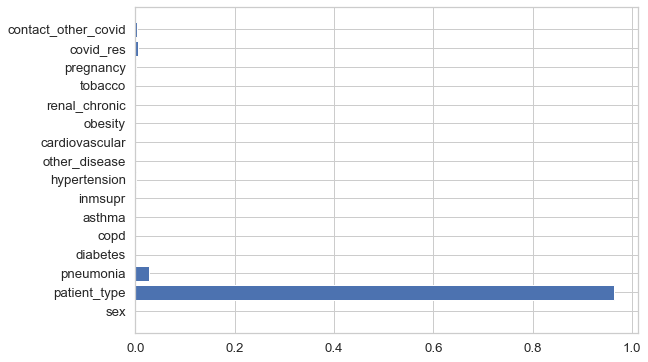

In [10]:
plt.barh(xtrain.columns, boost14.feature_importances_);

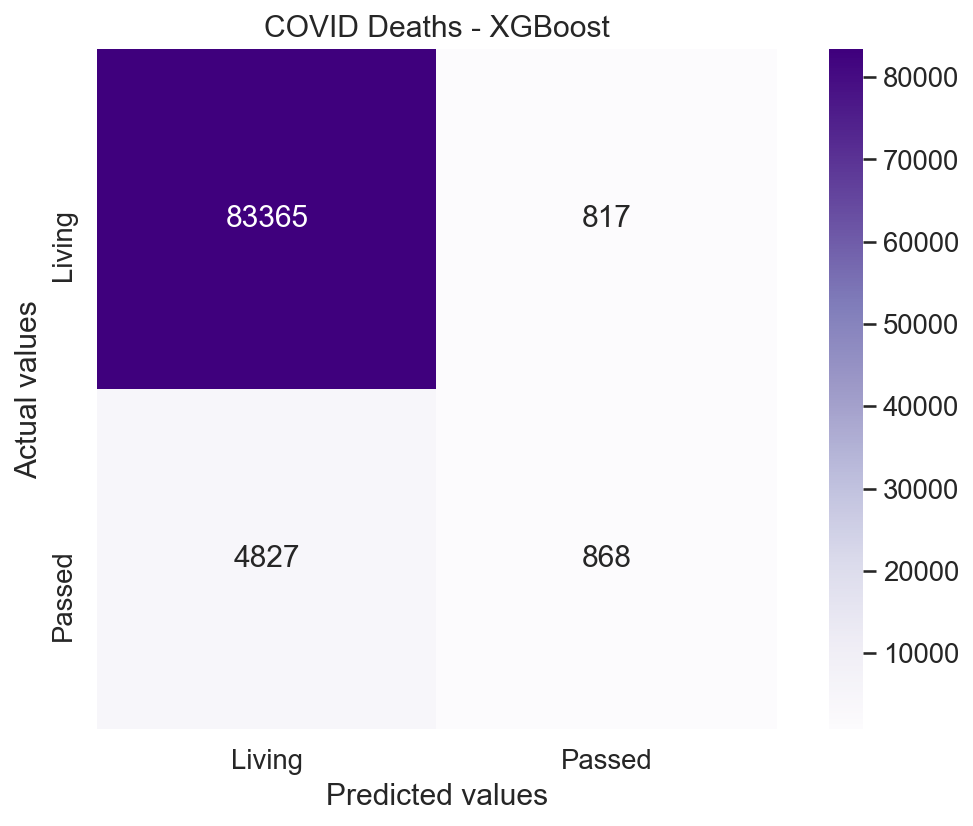

In [11]:
plt.figure(dpi=150)
sns.heatmap(gbm14_cm, cmap=plt.cm.Purples, annot=True, fmt='d', square=True,
           xticklabels=['Living', 'Passed'],
           yticklabels=['Living', 'Passed'])

plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('COVID Deaths - XGBoost')
plt.savefig('COVID_XGB_conf_matrix', dpi=600, bbox_inches='tight');

### XGBoost Conclusions

XGBoost was able to get some better precision and recall on the minority class, the mortality class, than the logistic regression model.  However, the overall accuracy and F1 were very close.  

Looking at the feature importance, it is clear that the overwhelming weight is placed on the patient_type feature.  I had already considered focusing in on only the hospitalized/inpatient patient_type, in order to parse out finer distinctions in the other features. This will likely also address a great deal of our class imbalance.

In [12]:
# to save xgb model as json automatically
boost14.save_model('xgb_full_data_model.json')

### Hospitalization / Inpatient Dataset

In [13]:
covid_hosp = pd.read_json('covid_hosp.json', lines=True)

In [14]:
features = ['sex','patient_type', 'pneumonia', 'diabetes', 'copd', 'asthma', 'inmsupr',
       'hypertension', 'other_disease', 'cardiovascular', 'obesity',
       'renal_chronic', 'tobacco', 'pregnancy',  'covid_res',
       'contact_other_covid']

xh = covid_hosp[features]
yh = covid_hosp['passed']

# train / test split
xtrainh, xtesth, ytrainh, ytesth = train_test_split(xh, yh, test_size=0.2, \
                                                random_state=33, \
                                                stratify = yh.values)

# train /validation split
xtrainh, xvalh, ytrainh, yvalh = train_test_split(xtrainh, ytrainh, test_size=0.2, \
                                             random_state=33,\
                                             stratify=ytrainh.values)

In [17]:
boost_h1 = xgb.XGBClassifier(
            n_estimators=30000,
            max_depth=15,   
            objective='binary:logistic',
            use_label_encoder=False,
            learning_rate=.03, 
            subsample=1,          # row subsampling rate
            min_child_weight=2,  
            colsample_bytree=1)   #  feature subsampling rate

eval_set_h =[(xtrainh,ytrainh), (xvalh, yvalh)]

fit_model = boost_h1.fit(
            xtrainh, ytrainh,
            eval_set=eval_set,
            eval_metric='error',  # metric: classification error. could also use AUC,etc
            early_stopping_rounds=50,
            verbose=False)

In [20]:
gbm_h1_cm = confusion_matrix(yvalh, boost_h1.predict(xvalh))
gbm_h1_cm

array([[13407,   729],
       [ 4393,   731]])

In [25]:
# training set
print(classification_report(ytrainh, boost_h1.predict(xtrainh)))

              precision    recall  f1-score   support

           0       0.76      0.95      0.85     56540
           1       0.56      0.16      0.25     20497

    accuracy                           0.74     77037
   macro avg       0.66      0.56      0.55     77037
weighted avg       0.71      0.74      0.69     77037



In [21]:
# validation set
print(classification_report(yvalh, boost_h1.predict(xvalh)))

              precision    recall  f1-score   support

           0       0.75      0.95      0.84     14136
           1       0.50      0.14      0.22      5124

    accuracy                           0.73     19260
   macro avg       0.63      0.55      0.53     19260
weighted avg       0.69      0.73      0.68     19260



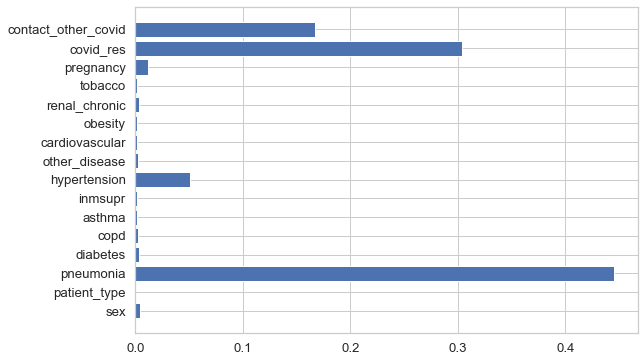

In [26]:
plt.barh(xtrainh.columns, boost_h1.feature_importances_);

### Immunosuppression Dataset

In [15]:
covid_immun = pd.read_json('covid_immun.json', lines=True)

In [16]:
features = ['sex','patient_type', 'pneumonia', 'diabetes', 'copd', 'asthma', 'inmsupr',
       'hypertension', 'other_disease', 'cardiovascular', 'obesity',
       'renal_chronic', 'tobacco', 'pregnancy',  'covid_res',
       'contact_other_covid']

xi = covid_clean[features]
yi = covid_clean['passed']

# train / test split
xtraini, xtesti, ytraini, ytesti = train_test_split(xi, yi, test_size=0.2, \
                                                random_state=33, \
                                                stratify = yi.values)

# train /validation split
xtraini, xvali, ytraini, yvali = train_test_split(xtraini, ytraini, test_size=0.2, \
                                             random_state=33,\
                                             stratify=ytraini.values)

In [18]:
boost_i1 = xgb.XGBClassifier(
            n_estimators=30000,
            max_depth=15,   
            objective='binary:logistic',
            use_label_encoder=False,
            learning_rate=.03, 
            subsample=1,          # row subsampling rate
            min_child_weight=2,  
            colsample_bytree=1)   #  feature subsampling rate

eval_set_i =[(xtraini,ytraini), (xvali, yvali)]

fit_model = boost_i1.fit(
            xtraini, ytraini,
            eval_set=eval_set,
            eval_metric='error',  # metric: classification error. could also use AUC,etc
            early_stopping_rounds=50,
            verbose=False)

In [22]:
gbm_i1_cm = confusion_matrix(yvali, boost_i1.predict(xvali))
gbm_i1_cm

array([[83307,   875],
       [ 4825,   870]])

In [24]:
# train set
print(classification_report(ytraini, boost_i1.predict(xtraini)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    336728
           1       0.58      0.18      0.27     22779

    accuracy                           0.94    359507
   macro avg       0.76      0.59      0.62    359507
weighted avg       0.92      0.94      0.92    359507



In [23]:
# validation set
print(classification_report(yvali, boost_i1.predict(xvali)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     84182
           1       0.50      0.15      0.23      5695

    accuracy                           0.94     89877
   macro avg       0.72      0.57      0.60     89877
weighted avg       0.92      0.94      0.92     89877



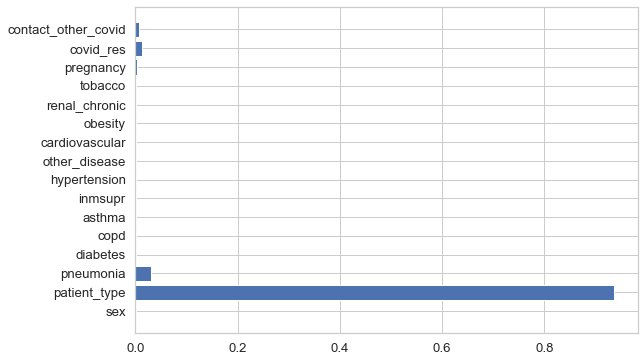

In [27]:
plt.barh(xtraini.columns, boost_i1.feature_importances_);

In [28]:
covid_immun['patient_type'].value_counts()

1    4679
0    4225
Name: patient_type, dtype: int64